In [1]:
import datetime
import pandas as pd
import numpy as np
import sklearn #1.2.2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc, accuracy_score, f1_score, precision_score
from sklearn import model_selection
from sklearn import tree
from sklearn.utils import resample
from joblib import dump, load
import pickle
import time
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE 

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Figures

# Effect of site of action

   Baseline (nM)  Half Life, $t_{1/2}$ (hr)  Binding constant, $K_D$ (nM)  \
2      91.090506                 250.449271                      0.037052   
5       2.661365                   0.115306                      0.026065   
7       0.001957                   0.738895                      0.011138   
8      17.649276                   0.020818                      0.031736   
9     106.259074                   0.042174                      0.005415   

   y_test  y_pred    site  
2     0.0     1.0  Plasma  
5     1.0     1.0  Plasma  
7     1.0     1.0  Plasma  
8     1.0     1.0  Plasma  
9     1.0     1.0  Plasma  


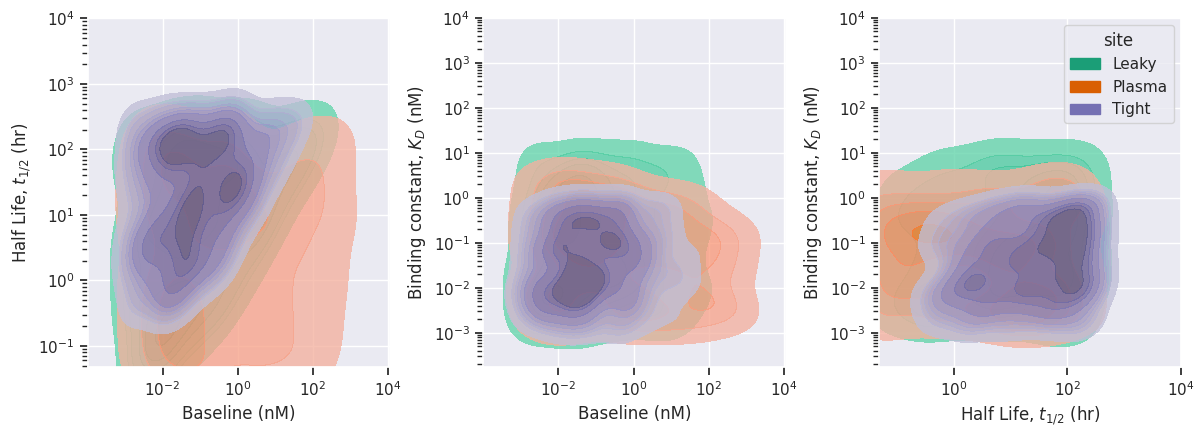

In [3]:
df_siteL = pd.read_csv('results/TestvPred1mgpkg_q2w_Tm_2last_10000.csv')
df_siteL['site'] = 'Leaky'
df_siteT = pd.read_csv('results/TestvPred1mgpkg_q2w_Tm_1last_10000.csv')
df_siteT['site'] = 'Tight'
df_siteP = pd.read_csv('results/TestvPred1mgpkg_q2w_Tm_plast_10000.csv')
df_siteP['site'] = 'Plasma'

df_site = pd.concat([df_siteP, df_siteL, df_siteT])
df_site = df_site[df_site.y_pred==1]
df_site = df_site.drop(columns=['Unnamed: 0'])
df_site = df_site.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})
print(df_site.head(5))

# site of action
fig5 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    gpx = sns.kdeplot(data=df_site[pair], x=pair[0], y=pair[1], hue=df_site['site'], hue_order = ['Leaky', 'Plasma', 'Tight'], palette="Dark2", alpha=0.78, fill=True, log_scale=True)
    #gpx.set_xscale('log')
    #gpx.set_yscale('log')
    gpx.set_ylim([min(df_site[pair[1]])-100, max(df_site[pair[1]]) + 10000])
    gpx.set_xlim([min(df_site[pair[0]])-100, max(df_site[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(False)

ax.get_legend().set_visible(True)
plt.show()
# fig5.savefig('results/1mgpkg_q2w_Ts_SoA.jpeg', dpi=300)


# Effect of soluble or membrane bound receptor

   Baseline (nM)  Half Life, $t_{1/2}$ (hr)  Binding constant, $K_D$ (nM)  \
0       0.017241                  12.558332                      0.096775   
2       0.026008                   0.020369                      0.001365   
3      22.534284                 138.506947                      0.002278   
4       0.186228                   0.154930                      0.652406   
5       0.068996                   0.236039                      0.047059   

   y_test  y_pred     Form  
0     1.0     1.0  soluble  
2     1.0     1.0  soluble  
3     1.0     1.0  soluble  
4     1.0     1.0  soluble  
5     1.0     1.0  soluble  


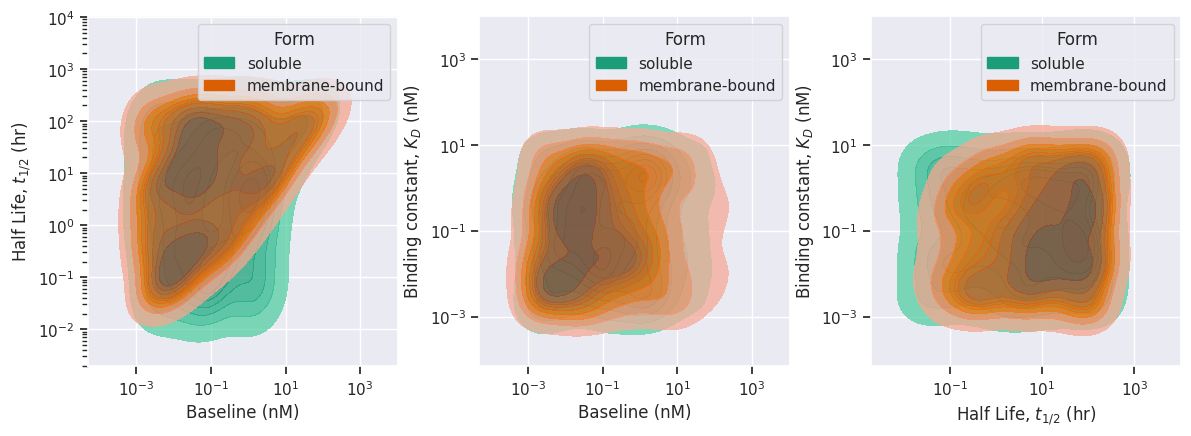

In [4]:
df_Ts = pd.read_csv('results/TestvPred1mgpkg_q2w_Ts_2last_10000.csv')
df_Ts['Form'] = 'soluble'
df_Tm = pd.read_csv('results/TestvPred1mgpkg_q2w_Tm_2last_10000.csv')
df_Tm['Form'] = 'membrane-bound'

df_form = pd.concat([df_Ts, df_Tm])
df_form = df_form[df_form.y_pred==1]
df_form = df_form.drop(columns=['Unnamed: 0'])
df_form = df_form.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})
print(df_form.head(5))

fig6 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_form[pair], x=pair[0], y=pair[1], hue=df_form['Form'], palette='Dark2', hue_order = ['soluble', 'membrane-bound'], alpha=0.75, fill=True, log_scale=True)
    #gpx.set_xscale("log")
    #gpx.set_yscale("log")
    gpx.set_ylim([min(df_form[pair[1]])-100, max(df_form[pair[1]]) + 10000])
    gpx.set_xlim([min(df_form[pair[0]])-100, max(df_form[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(True)

ax.get_legend().set_visible(True)
plt.show()
#fig6.savefig('results/1mgpkg_q2w_2min_receptor_form.jpeg', dpi=300)

# Dose dependence

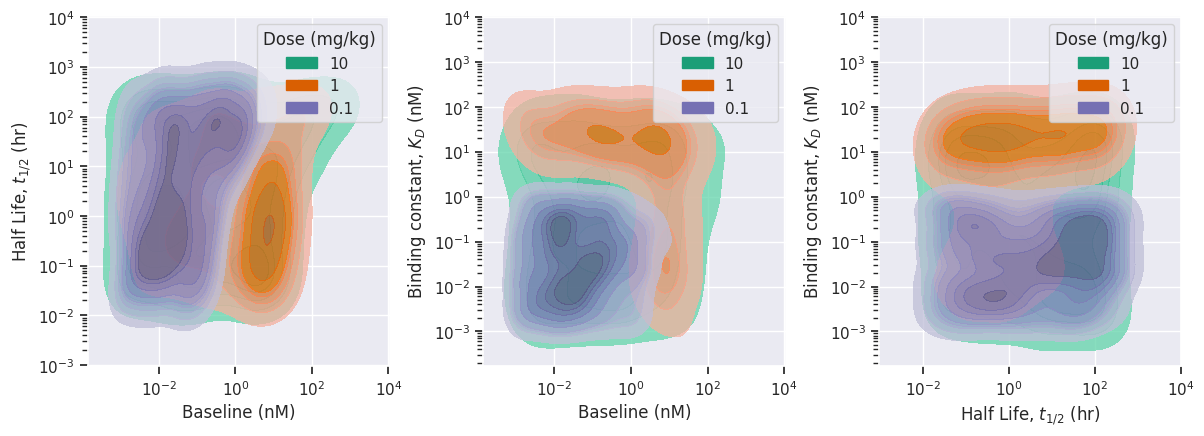

In [5]:
df_p1 = pd.read_csv('results/TestvPred0.1mgpkg_q2w_Ts_plast_10000.csv')
df_p1['Dose (mg/kg)'] = 0.1
df_1 = pd.read_csv('results/TestvPred1mgpkg_q2w_Ts_plast_10000.csv')
df_1['Dose (mg/kg)'] = 1
df_10 = pd.read_csv('results/TestvPred10mgpkg_q2w_Ts_plast_10000.csv')
df_10['Dose (mg/kg)'] = 10


df_dose = pd.concat([df_p1, df_1, df_10])
df_dose = df_dose[df_dose.y_pred==1]
df_dose = df_dose.drop(columns=['Unnamed: 0'])
df_dose = df_dose.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})

fig7 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_dose[pair], x=pair[0], y=pair[1], hue=df_dose['Dose (mg/kg)'], palette='Dark2', hue_order = [10, 1, 0.1], alpha=0.75, fill=True, log_scale=True)
    gpx.set_ylim([min(df_dose[pair[1]])-100, max(df_dose[pair[1]]) + 10000])
    gpx.set_xlim([min(df_dose[pair[0]])-100, max(df_dose[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(True)

ax.get_legend().set_visible(True)
plt.show()
# fig7.savefig('results/q2w_plast_dose.jpeg', dpi=300)

# Dosing scheme (q1w, q2w, q4w)


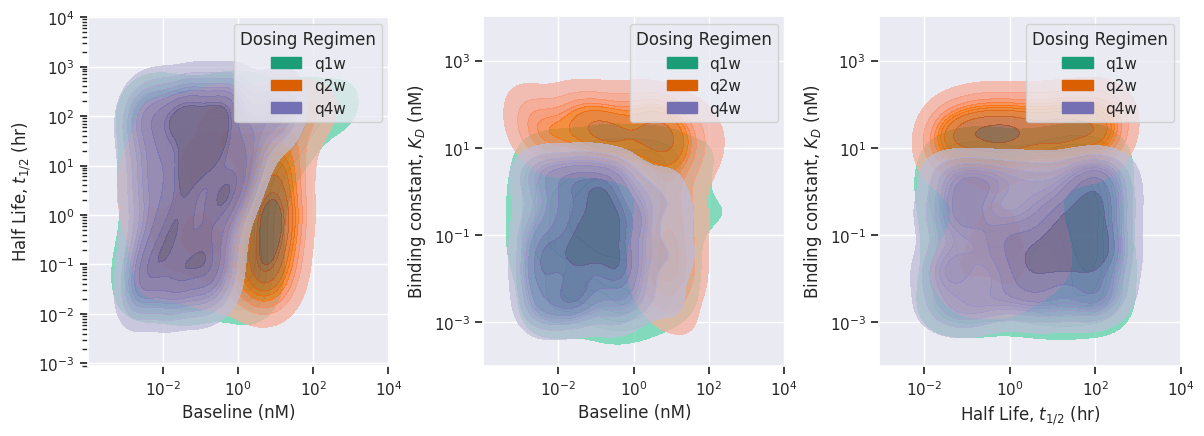

In [6]:
# dosing scheme (q1w, q2w, q4w)
df_q1w = pd.read_csv('results/TestvPred1mgpkg_q1w_Ts_plast_10000.csv')
df_q1w['Dosing Regimen'] = 'q1w'
df_q2w = pd.read_csv('results/TestvPred1mgpkg_q2w_Ts_plast_10000.csv')
df_q2w['Dosing Regimen'] = 'q2w'
df_q4w = pd.read_csv('results/TestvPred1mgpkg_q4w_Ts_plast_10000.csv')
df_q4w['Dosing Regimen'] = 'q4w'


df_reg = pd.concat([df_q1w, df_q2w, df_q4w])
df_reg = df_reg[df_reg.y_pred==1]
df_reg = df_reg.drop(columns=['Unnamed: 0'])
df_reg = df_reg.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})

fig8 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_reg[pair], x=pair[0], y=pair[1], hue=df_reg['Dosing Regimen'], palette='Dark2', hue_order = ['q1w', 'q2w', 'q4w'], alpha=0.75, fill=True, log_scale=True)
    #gpx.set_xscale("log")
    #gpx.set_yscale("log")
    gpx.set_ylim([min(df_reg[pair[1]])-100, max(df_reg[pair[1]]) + 10000])
    gpx.set_xlim([min(df_reg[pair[0]])-100, max(df_reg[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(True)

ax.get_legend().set_visible(True)
plt.show()
#fig8.savefig('results/1mgpkg_plast_dosing_reg.jpeg', dpi=300)

# Charge-dependence  (-5, 0, +5)


In [9]:
# charge-dependence  (-5, 0, +5)
df_p5 = pd.read_csv('results/TestvPred1mgpkg_+5_q2w_Ts_plast_10000.csv')
df_p5['Charge'] = '+5'
df_m5 = pd.read_csv('results/TestvPred1mgpkg_-5_q2w_Ts_plast_10000.csv')
df_m5['Charge'] = '-5'
df_nt = pd.read_csv('results/TestvPred1mgpkg_q2w_Ts_plast_10000.csv')
df_nt['Charge'] = '0'

df_charge = pd.concat([df_p5, df_m5, df_nt])
df_charge = df_charge[df_charge.y_pred==1]
df_charge = df_charge.drop(columns=['Unnamed: 0'])
df_charge = df_charge.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})

fig9 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_charge[pair], x=pair[0], y=pair[1], hue=df_charge['Charge'], palette='Dark2', hue_order = ['-5', '0', '+5'], alpha=0.68, fill=True, log_scale=True)
    
    gpx.set_ylim([min(df_charge[pair[1]])-100, max(df_charge[pair[1]]) + 10000])
    gpx.set_xlim([min(df_charge[pair[0]])-100, max(df_charge[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(False)

ax.get_legend().set_visible(True)
plt.show()
# fig9.savefig('results/1mgpkg_plast_charge.jpeg', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'results/TestvPred1mgpkg_-5_q2w_Ts_plast_10000.csv'

# 1 mg/kg Q4W scenario for validation

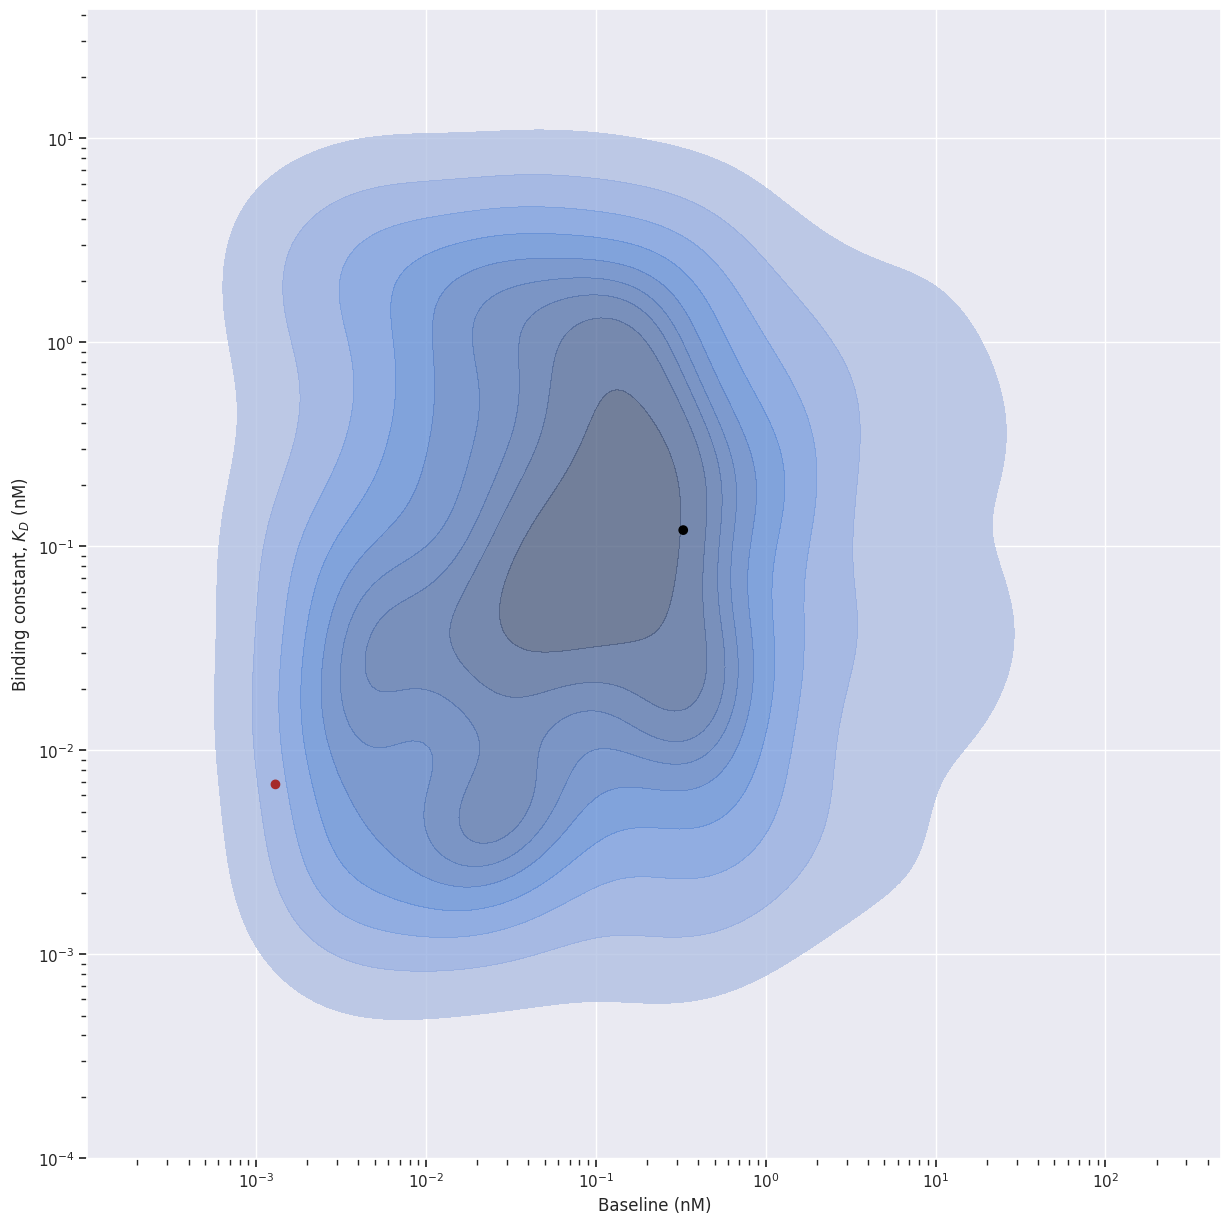

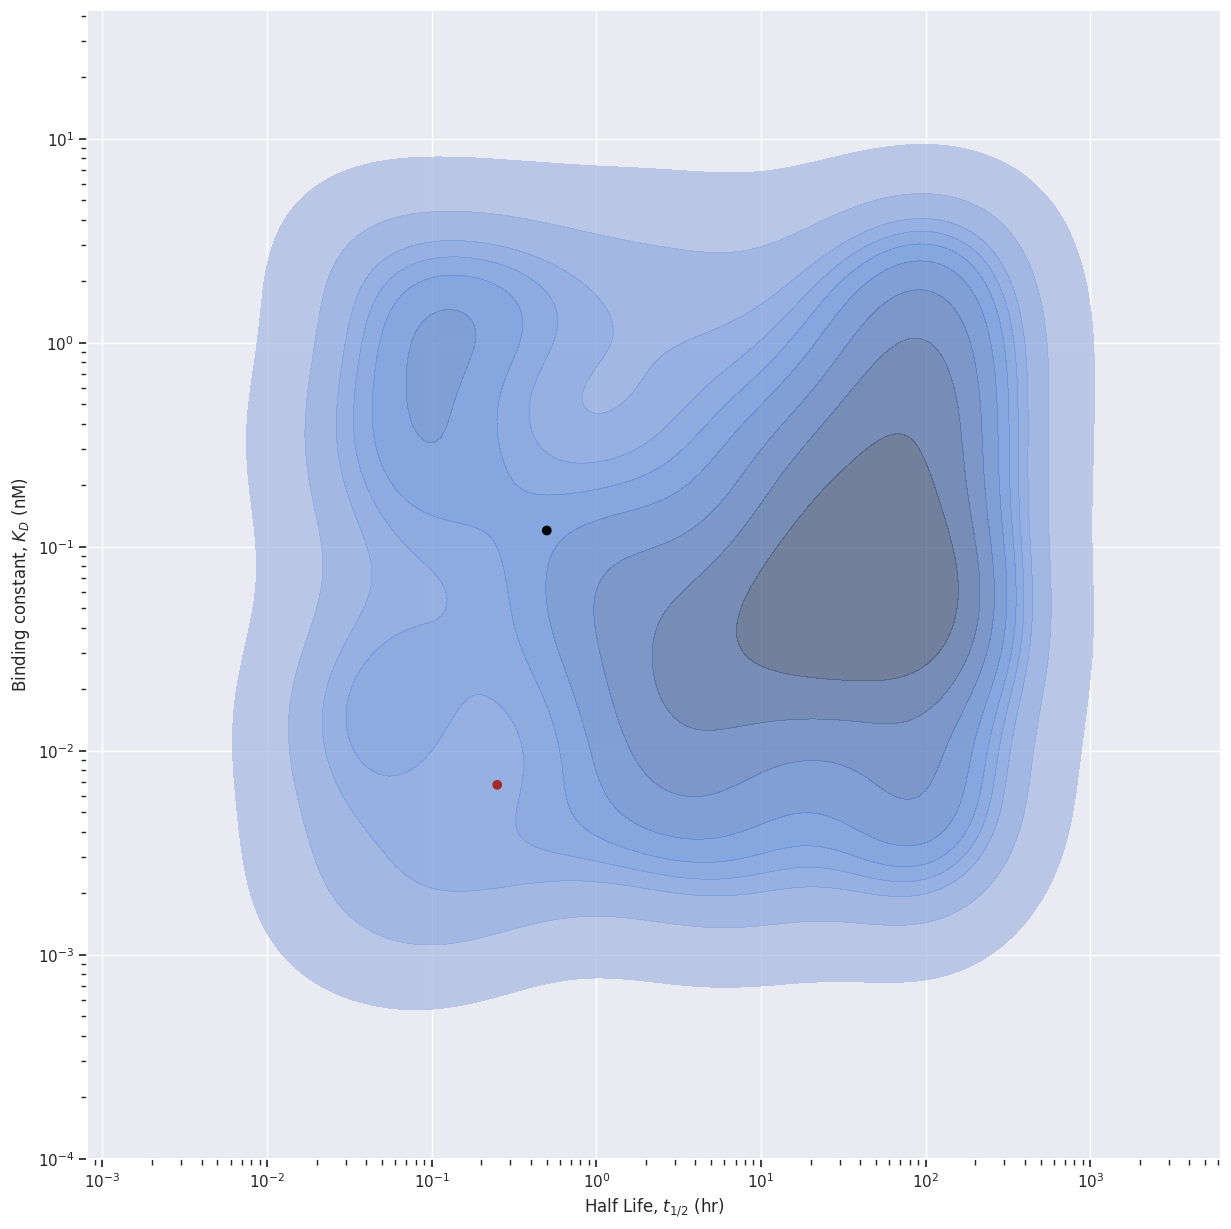

In [8]:
# dosing scheme (q1w, q2w, q4w)

df_q4w = pd.read_csv('results/TestvPred1mgpkg_q4w_Ts_plast_10000.csv')
df_q4w['Dosing Regimen'] = 'q4w'


df_reg = pd.concat([df_q4w])
df_reg = df_reg[df_reg.y_pred==1]
df_reg = df_reg.drop(columns=['Unnamed: 0'])
df_reg = df_reg.rename(columns={'T0': 'Baseline (nM)', 'thalf':'Half Life, $t_{1/2}$ (hr)', 'KD':'Binding constant, $K_D$ (nM)'})

fig9 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)',  'Binding constant, $K_D$ (nM)']]): # ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(1, 1, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_reg[pair], x=pair[0], y=pair[1], hue=df_reg['y_pred'], alpha=0.75, fill=True, log_scale=True)
    #gpx.set_xscale("log")
    #gpx.set_yscale("log")
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(False)
    plt.scatter([0.0013, 0.327], [0.0068, 0.12], color=['brown', 'black'])

plt.show()

fig9.savefig('results/1mgpkg_Q4W_val1.jpeg', dpi=300)

fig10 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): # 
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(1, 1, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    
    gpx = sns.kdeplot(data=df_reg[pair], x=pair[0], y=pair[1], hue=df_reg['y_pred'], alpha=0.75, fill=True, log_scale=True)
    #gpx.set_xscale("log")
    #gpx.set_yscale("log")
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(False)
    plt.scatter([0.25, 0.5], [0.0068, 0.12], color=['brown', 'black'])

plt.show()
fig10.savefig('results/1mgpkg_Q4W_val2.jpeg', dpi=300)
